Tester la visualisation avec Detectron2

Voir ici: https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b



In [1]:
import random
import os
import cv2
import logging

from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

import detectron2.utils.comm as comm
from detectron2.utils.logger import log_every_n_seconds
from detectron2.engine.hooks import HookBase
from LossEvalHook import LossEvalHook 

# Tensorboard
from detectron2.utils.logger import setup_logger
from detectron2.utils.events import EventStorage, JSONWriter
setup_logger()


from detectron2.data import build_detection_test_loader
import matplotlib.pyplot as plt
import cv2

import matplotlib.pyplot as plt
import numpy as np




In [2]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        #self.trainer.storage.put_scalars(timetest=12)
        
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

    


In [3]:

DatasetCatalog.clear()
MetadataCatalog.clear()

# Register the train, test, and validation datasets
register_coco_instances("train_particles_v8", {}, 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/train/_annotations.coco.json", 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/train")
register_coco_instances("test_particles_v8", {}, 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/test/_annotations.coco.json", 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/test")
register_coco_instances("val_particles_v8", {}, 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/valid/_annotations.coco.json", 
                        "../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/valid")

# Define metadata for your classes
MetadataCatalog.get("train_particles_v8").set(thing_classes=["particle"])
MetadataCatalog.get("test_particles_v8").set(thing_classes=["particle"])
MetadataCatalog.get("val_particles_v8").set(thing_classes=["particle"])

namespace(name='val_particles_v8',
          json_file='../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/valid/_annotations.coco.json',
          image_root='../../../0_DATA/IMPTOX/01-01_image_library/V4/download_v8/valid',
          evaluator_type='coco',
          thing_classes=['particle'])

In [11]:

cfg = get_cfg()
cfg.OUTPUT_DIR = "./TrainDetectron2Model_augmented"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.merge_from_file(
    "../../Other/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    #"../../Other/detectron2/configs/Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
) # Detectron2 accidentally installed at more than one place

# Specify the train, test, and validation subsets in your Detectron2 configuration
cfg.DATASETS.TRAIN = ("train_particles_v8",)
cfg.DATASETS.TEST = ("test_particles_v8",)  # Possible to later change the test set
cfg.DATASETS.VAL = ("val_particles_v8",) # You can add validation dataset here if you want to evaluate during training
cfg.DATALOADER.NUM_WORKERS = 2

# Before training
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.DEVICE = 'cuda:1'  # cpu or cuda:0-1
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0015
cfg.SOLVER.MAX_ITER = 2000 # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 10  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class: particle

cfg.TEST.EVAL_PERIOD = 10

# SOLVER.IMS_PER_BATCH is what's commonly known as batch size in deep learning and refers to the number of training examples utilized in one iteration.

# MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE is a parameter that is used to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training.


In [12]:
# Remove metrics file 

!rm ./TrainDetectron2Model_augmented/metrics.json


rm: cannot remove './TrainDetectron2Model_augmented/metrics.json': No such file or directory


In [13]:
%%capture



trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/06 09:14:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Le json ne contient pas les bonnes données

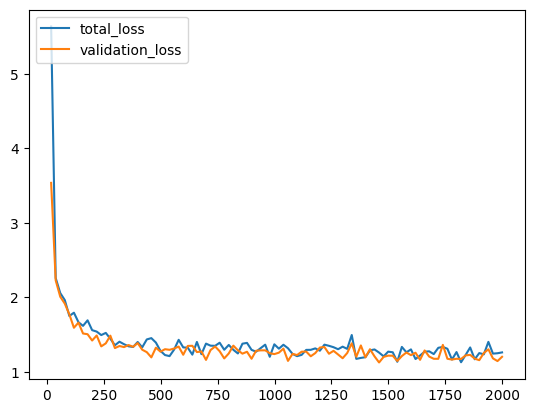

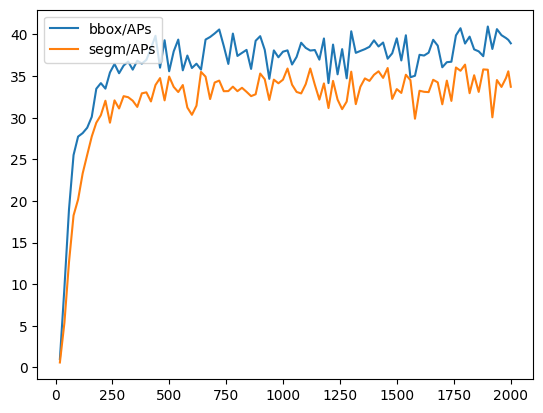

In [14]:
import json
import matplotlib.pyplot as plt

experiment_folder = './TrainDetectron2Model_augmented' #./TrainDetectron2Model_augmented

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')


#and 'eta_seconds' in x and x['eta_seconds'] == 0.0


plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()



plt.plot([x['iteration'] for x in experiment_metrics if 'bbox/APs' in x], 
         [x['bbox/APs'] for x in experiment_metrics if 'bbox/APs' in x])
plt.plot([x['iteration'] for x in experiment_metrics if 'segm/APs' in x], 
         [x['segm/APs'] for x in experiment_metrics if 'segm/APs' in x])
plt.legend(['bbox/APs', 'segm/APs'], loc='upper left')
plt.show()

